# UCLA model without visual attributes applied to the ITU + UCLA set

This notebook is aimed at running the UCLA original network without visual attributes to the combination of the ITU + UCLA datasets

In [1]:
from protestDB import cursor
import time
from protestDB import models
from lib import analysis_utils as au
import pandas as pd
import os
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
import scipy
from keras import backend as Kbackend
from keras import callbacks as Kcallbacks
from keras import optimizers as Koptimizers
from keras import losses as Klosses
from keras import models as Kmodels
from keras import backend as Kbackend
from keras import applications as Kapplications
from keras import layers as Klayers
import h5py
import itertools
from lib import transforms

/home/lucas/Documents/ITU/Thesis_2018/venv/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Loading up the data

In [4]:
pc = cursor.ProtestCursor()
imgs_UCLA = pc.getLabelledImagesAndNonProtest(source="UCLA", label_source="combined")
imgs_ITU = pc.getLabelledImagesAndNonProtest(source="Luca Rossi - ECB", label_source="combined")

print (len(imgs_UCLA), " UCLA images, both protest and non protest")
print (len(imgs_ITU), " ITU images, both protest and non protest")


40720  UCLA images, both protest and non protest
3726  ITU images, both protest and non protest


In [5]:
print("UCLA has ", len(imgs_UCLA[imgs_UCLA["protest"] == True]), "protest images, ", 
      len(imgs_UCLA[imgs_UCLA["protest"] == False]), "non protest images and  ",
      len(imgs_UCLA[imgs_UCLA["luca rossi"] == True]), " are from ITU dataset")

print("ITU has ", len(imgs_ITU[imgs_ITU["protest"] == True]), "protest images, ", 
      len(imgs_ITU[imgs_ITU["protest"] == False]), "non protest images and  ", 
      len(imgs_ITU[imgs_ITU["luca rossi"] == True]), " are from ITU dataset")

UCLA has  11646 protest images,  29074 non protest images and   0  are from ITU dataset
ITU has  0 protest images,  3726 non protest images and   3726  are from ITU dataset


### Preprocessing

In [6]:
# assign protest tag to itu images that have labels
indx_ITU_protest = imgs_ITU['label'].notnull()
imgs_ITU.loc[indx_ITU_protest, "protest"] = True

In [7]:
print("UCLA has ", len(imgs_UCLA[imgs_UCLA["protest"] == True]), "protest images, ", 
      len(imgs_UCLA[imgs_UCLA["protest"] == False]), "non protest images and  ",
      len(imgs_UCLA[imgs_UCLA["luca rossi"] == True]), " are from ITU dataset")

print("ITU has ", len(imgs_ITU[imgs_ITU["protest"] == True]), "protest images, ", 
      len(imgs_ITU[imgs_ITU["protest"] == False]), "non protest images and  ", 
      len(imgs_ITU[imgs_ITU["luca rossi"] == True]), " are from ITU dataset")

UCLA has  11646 protest images,  29074 non protest images and   0  are from ITU dataset
ITU has  1000 protest images,  2726 non protest images and   3726  are from ITU dataset


In [8]:
# combined datasets
df_combined = imgs_UCLA.append(imgs_ITU)
len(df_combined)

44446

### Preprocessing

In [9]:
# rename som
cols = ["name", "label", "protest", "luca rossi"]
imgs = df_combined[cols].copy()
imgs = imgs.rename(columns={"label": "violence"})
imgs

,name,violence,protest,luca rossi
imageHASH,,,,
030d92ca8d1f4b6b,test-00000.jpg,0.217776,True,False
c7c6cecccc6ae6a4,test-00001.jpg,NaN,False,False
94c4c6443cbc9c14,test-00002.jpg,0.127544,True,False
f2f068703a38e869,test-00003.jpg,NaN,False,False
83a2860706c6e5e4,test-00004.jpg,NaN,False,False
1890151c5859c8f8,test-00005.jpg,NaN,False,False
7f5b59cbdc543c2c,test-00006.jpg,NaN,False,False
6264e0c0a0c0a0d0,test-00007.jpg,NaN,False,False
eee6e6e6c68f95b5,test-00008.jpg,NaN,False,False


In [10]:
# guarantee that all images that have violence labels have protest tags and vice versa
imgs_no_violence_labels = imgs[imgs['violence'].isnull()]
print(len(imgs_no_violence_labels[imgs_no_violence_labels["protest"] == True]))
imgs_violence_label = imgs[imgs['violence'].notnull()]
print(len(imgs_violence_label[imgs_violence_label["protest"] == False]))

0
0


In [11]:
# Remove images with scores higher than cut point
cutpoint = 0.43

# get images with lower cutpoint, and images non protest related
imgs_lower_cutpoint = imgs[imgs["violence"] <= 0.43].copy()
imgs_filtered = imgs_lower_cutpoint.append(imgs[imgs["protest"] == False])

#save index of images without violence score
indx_non_violence = imgs_filtered['violence'].isnull()

# normalize
imgs_filtered = au.minMax(imgs_filtered, 'violence')

# mask values that did not had violence labels
imgs_filtered.loc[indx_non_violence, "violence"] = -1

df = imgs_filtered
print(len(imgs) - len(df), " images were removed")

125  images were removed


In [12]:
print("df has ", len(df[df["protest"] == True]), "protest images, ", 
      len(df[df["protest"] == False]), "non protest images and  ", 
      len(df[df["luca rossi"] == True]), " are from ITU dataset")

df has  12521 protest images,  31800 non protest images and   3609  are from ITU dataset


In [13]:
df

,name,violence,protest,luca rossi
imageHASH,,,,
030d92ca8d1f4b6b,test-00000.jpg,0.508508,True,False
94c4c6443cbc9c14,test-00002.jpg,0.297815,True,False
0b2cf29e92aa294f,test-00010.jpg,0.448857,True,False
160335f46456562e,test-00013.jpg,0.262511,True,False
6a22e2626c464360,test-00020.jpg,0.299641,True,False
7864656be2a2260b,test-00028.jpg,0.408410,True,False
a494c469ac8e8ec4,test-00029.jpg,0.461789,True,False
94d0f7b39ebce000,test-00030.jpg,0.261996,True,False
195acace4e4b65c4,test-00037.jpg,0.454666,True,False


### Divide the data

In [14]:
n_folds = 5
seed = 300

In [15]:
k_folds = au.getKSplitsTwoClassesStratified(df, n_folds, "protest", "luca rossi", seed )
for i in k_folds:
    print("kfold has ", len(i[i["protest"] == True]), "protest images, ", 
          len(i[i["protest"] == False]), "non protest images and  ",
          len(i[i["luca rossi"] == True]), " are from ITU dataset")

kfold has  2503 protest images,  6359 non protest images and   721  are from ITU dataset
kfold has  2503 protest images,  6359 non protest images and   721  are from ITU dataset
kfold has  2503 protest images,  6359 non protest images and   721  are from ITU dataset
kfold has  2503 protest images,  6359 non protest images and   721  are from ITU dataset
kfold has  2509 protest images,  6364 non protest images and   725  are from ITU dataset


In [16]:
sample_fold = k_folds[0]

kfold_ITU = sample_fold[sample_fold["luca rossi"] == True].copy()
kfold_UCLA = sample_fold[sample_fold["luca rossi"] == False].copy()

print("df_ITU has ", len(kfold_ITU[kfold_ITU["protest"] == True]), "protest images, ", 
      len(kfold_ITU[kfold_ITU["protest"] == False]), "non protest images")

print("df_UCLA has ", len(kfold_UCLA[kfold_UCLA["protest"] == True]), "protest images, ", 
      len(kfold_UCLA[kfold_UCLA["protest"] == False]), "non protest images")

df_ITU has  176 protest images,  545 non protest images
df_UCLA has  2327 protest images,  5814 non protest images


In [17]:
# print first fold
k_folds[0]

,name,violence,protest,luca rossi
imageHASH,,,,
c4c898d0d8a4cccc,train-03913.jpg,-1.000000,False,False
e0f0b0b020a5c04a,train-27199.jpg,-1.000000,False,False
939198985adacc6c,test-05058.jpg,-1.000000,False,False
4ddbdad99d55d74d,test-07498.jpg,-1.000000,False,False
256452ccd3938e89,test-06995.jpg,-1.000000,False,False
818cc8c9d1dad8c4,train-13900.jpg,-1.000000,False,False
6e4e1e1e3c38363e,train-29928.jpg,0.775844,True,False
26d1d361388ce422,test-00282.jpg,-1.000000,False,False
33bb9b736196696d,train-22109.jpg,-1.000000,False,False


In [18]:
validation_df = k_folds[0].copy()
test_df = k_folds[1].copy()
train_df = k_folds[2].copy().append(k_folds[3].copy()).append(k_folds[4].copy())
print("train set has ", len(train_df) , " images. validation has ", len(validation_df), " images and test has ", len(test_df))

train set has  26597  images. validation has  8862  images and test has  8862


### Test generator

In [19]:
batch_size = 32

In [20]:

dummy_test_generator = au.ResizeSequence(
    train_df[np.random.randint(100):np.random.randint(100, 200)],
    batch_size, 
    targets = ['protest', 'violence'],
    transforms = [
        transforms.randomResizedCrop,
        transforms.randomRotation,
        transforms.randomHorizontalFlip,
        transforms.colorJitter,
        transforms.normalizeMinMax,
        transforms.lighting,
        transforms.normalizeStandardScore
    ] 
)



first = next(dummy_test_generator.__iter__())
image = first[0][0]
protest = first[1][0]
violence = first[1][1]
img = np.array(image)
plt.imshow(img)
print("protest has shape", protest.shape, " violence has shape", violence.shape)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


protest has shape (32,)  violence has shape (32,)


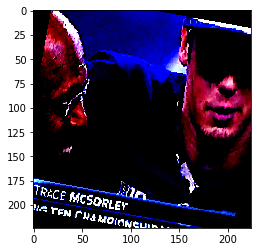

In [21]:
first = next(dummy_test_generator.__iter__())
image = first[0][0]
protest = first[1][0]
violence = first[1][1]
img = np.array(image)
plt.imshow(img)
print("protest has shape", protest.shape, " violence has shape", violence.shape)

### Training

In [23]:
mask_value = -1; lr = 0.01; momentum = 0.9; epochs = 100; patience = 10

In [24]:
hyper_params_name = "momentum-{}_batch_size-{}_n_folds-{}_n_folds_seed-{}".format(momentum, batch_size, n_folds,seed)
hyper_params_name

'momentum-0.9_batch_size-32_n_folds-5_n_folds_seed-300'

In [25]:
# COMMENT THIS OUT FOR RUN WITH THE WHOLE DATA SET
#size_sample = 34
#validation_df = validation_df[:34]
#test_df = test_df[:34]
#train_df = train_df[:34]

In [26]:
train_generator = au.ResizeSequence(
    train_df,
    batch_size, 
    targets = ['protest', 'violence'],
    transforms = [
        transforms.randomResizedCrop,
        transforms.randomRotation,
        transforms.randomHorizontalFlip,
        transforms.colorJitter,
        transforms.normalizeMinMax,
        transforms.lighting,
        transforms.normalizeStandardScore
    ]
)
validation_generator = au.ResizeSequence(
    validation_df,
    batch_size, 
    targets = ['protest', 'violence'],
    transforms = [
        transforms.resize,
        transforms.centerCrop,
        transforms.normalizeMinMax,
        transforms.normalizeStandardScore
    ]
)

test_generator = au.ResizeSequence(
test_df,
batch_size, 
targets = ['protest', 'violence'],
transforms = [
    transforms.resize,
    transforms.centerCrop,
    transforms.normalizeMinMax,
    transforms.normalizeStandardScore
]
)



# Modeling start
Kbackend.clear_session()

model = au.initializeUCLAModelWithoutVisual()

optimizer = Koptimizers.SGD(lr=lr, momentum=momentum, nesterov=False)
model.compile(optimizer=optimizer,
          loss={'protest_out': Klosses.binary_crossentropy,
                'violence_out': au.buildMaskedLoss(Klosses.mean_squared_error, mask_value)},
          loss_weights={'protest_out': 1., 
                        'violence_out': 10 })
#model.summary()

try:
    __file__ # Apparently, this is not defined in the notebook,
         # but it will be when we start running on the server
         # (So when things gets real)
except NameError:
    __file__ = "test"


name = au.getExperimentName(__file__, len(df), epochs, lr, hyper_params_name)
csv_results = "models_preds/%s.csv" % name
model_checkout_path = "models/%s.hdf5" % name
csv_logger_path = "logs/%s.csv" % name
tensor_board_folder = os.path.join("logs", name)

if not os.path.exists(tensor_board_folder):
    os.makedirs(tensor_board_folder)

if not os.path.exists(tensor_board_folder):
    os.makedirs("logs")

if not os.path.exists(tensor_board_folder):
    os.makedirs("models")

if not os.path.exists(tensor_board_folder):
    os.makedirs("models_preds")

print("Writing model to: \t%s" % model_checkout_path)
print("Writing log to: \t%s\n" % csv_logger_path)



# callbacks
change_lr = Kcallbacks.LearningRateScheduler(
    au.lrUpdateUCLA, 
    verbose = True
)

checkpoint = Kcallbacks.ModelCheckpoint(
    model_checkout_path,
    monitor='val_loss', 
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    period=1
)

earlystop = Kcallbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0, 
    patience=patience,
    verbose=1, 
    mode='auto'
)

tensor_board = Kcallbacks.TensorBoard(
    log_dir=tensor_board_folder,
     histogram_freq=0,
     batch_size=32, 
     write_graph=True,
     write_grads=False, 
     write_images=False, 
     embeddings_freq=0,
     embeddings_layer_names=None,
     embeddings_metadata=None
)

csv_logger = Kcallbacks.CSVLogger(
    csv_logger_path, 
    separator=',', 
    append=False
)

history = model.fit_generator(
    train_generator,
    validation_data= validation_generator,
    epochs=epochs,
    callbacks = [change_lr, checkpoint, tensor_board, csv_logger, earlystop]
)


# Preds

# load the weights from the best model
model.load_weights(model_checkout_path)

preds = model.predict_generator(test_generator, verbose = 1)
preds_protest = preds[0][:len(test_df)] # avoid getting more than the needed
preds_violence = preds[1][:len(test_df)] 
print("protest shape is ", preds_protest.shape, " violence shape is ", preds_violence.shape)
# Creates a panda data frame with the results

test_fold_results = test_df.copy()
test_fold_results["pred_protest"] = preds_protest
test_fold_results["pred_violence"] = preds_violence

print("saving results")
test_fold_results.to_csv(csv_results)


Writing model to: 	models/test_datalen-44321_epochs-2_init_lr-0.01_momentum-0.9_batch_size-32_n_folds-5_n_folds_seed-300.hdf5
Writing log to: 	logs/test_datalen-44321_epochs-2_init_lr-0.01_momentum-0.9_batch_size-32_n_folds-5_n_folds_seed-300.csv

Epoch 1/2

Epoch 00001: LearningRateScheduler reducing learning rate to 0.009999999776482582.
2/2 [==============================] - 86s 43s/step - loss: 0.8066 - protest_out_loss: 0.6090 - violence_out_loss: 0.0198 - val_loss: 0.6722 - val_protest_out_loss: 0.4899 - val_violence_out_loss: 0.0182

Epoch 00001: val_loss improved from inf to 0.67217, saving model to models/test_datalen-44321_epochs-2_init_lr-0.01_momentum-0.9_batch_size-32_n_folds-5_n_folds_seed-300.hdf5
Epoch 2/2

Epoch 00002: LearningRateScheduler reducing learning rate to 0.009999999776482582.
2/2 [==============================] - 80s 40s/step - loss: 0.5285 - protest_out_loss: 0.4530 - violence_out_loss: 0.0076 - val_loss: 0.8088 - val_protest_out_loss: 0.5706 - val_violen